In [66]:
from mpi4py import MPI
import timeit
import numpy as np
import os
import meshio
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

from manapy.ddm import readmesh
from manapy.ddm import Domain

from manapy.tools.pyccel_tools import initialisation_gaussian_2d, update_new_value, time_step
                          
from manapy.fvm.pyccel_fvm import (explicitscheme_convective_2d,
                                   explicitscheme_dissipative)

#from manapy.ast import Variable, LinearSystem

start = timeit.default_timer()

# mesh directory

dim = 2
readmesh('square.msh', dim=dim, periodic=[0,0,0])

#Create the informations about cells, faces and nodes
domain = Domain(dim=dim)

faces = domain.faces
cells = domain.cells
halos = domain.halos
nodes = domain.nodes

nbnodes = domain.nbnodes
nbfaces = domain.nbfaces
nbcells = domain.nbcells


Starting ....
Number of Cells :  1720
Number of Nodes :  911


In [67]:
domain.nbcells

1720

In [68]:
#Cells Centre
Cells_centre= [cell[:-1] for cell in cells._center]

In [69]:

import numpy.linalg as LA

def circumcenter(C):
    ax = C[0][0]
    ay = C[0][1]
    bx = C[1][0]
    by = C[1][1]
    cx = C[2][0]
    cy = C[2][1]
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return (ux, uy)

def dist(x, y):
    x=np.asarray(x)
    y=np.asarray(y)
    return LA.norm(x - y)

def norm2(exact, Sol, volume, nbelements, order):      
    Error = np.zeros(nbelements)
    Ex = np.zeros(nbelements)
    for i in range(nbelements):
        Error[i] = np.fabs(Sol[i]- exact[i]) * volume[i]
        Ex[i] = np.fabs(exact[i]) * volume[i]

    ErrorL2 = np.linalg.norm(Error,ord=order)/np.linalg.norm(Ex,ord=order)
    return ErrorL2

def cell_ver_coor():
    Cells_Cord=[]
    for s in cells._nodeid :
        Cell_Cord =[]
        for i in s :
            Cell_Cord.append(nodes._vertex[i][:-2])
        Cells_Cord.append(Cell_Cord)   
    return Cells_Cord

Cells_Cord = cell_ver_coor()
#
#Cells_Cord

In [62]:
# Calcul de l'Orthocentre
Orthocentre = []
for i in range(nbcells):
    Orthocentre.append(circumcenter(Cells_Cord[i]))
#Orthocentre

In [64]:
dist(Orthocentre[0],Orthocentre[1])

1.4770561880469253

In [92]:
import numpy as np
def Sol_exact(x, y, alpha = 4):
    return np.exp(-1*(x**2+y**2)/0.25**2)


u_exact = [ Sol_exact(cell[0], cell[1]) for cell in domain.cells.center]
u_exact = np.array(u_exact)

save_n=0
save_paraview_one_variable(u_exact, cells._nodeid, nodes._vertex, 2, "res_VF4"+str(save_n))

# 3- Représentons $u_0$ et ses les isovaleurs de

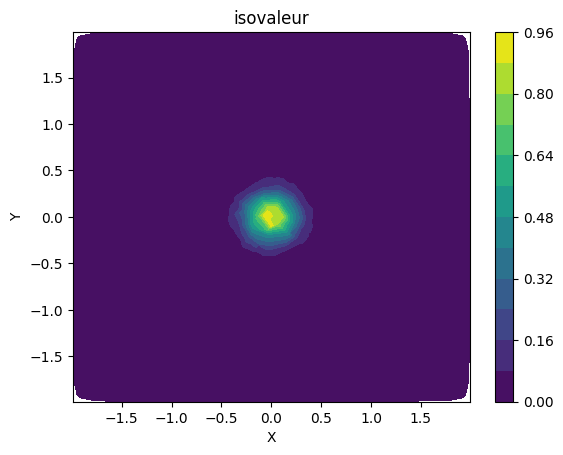

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
def plot_isovaleurs(Orthocentre, u):
   triang = Triangulation(Orthocentre[:, 0], Orthocentre[:, 1])
   plt.figure()
   plt.tricontourf(triang, u, levels=14)  # 14 niveaux de contour
   plt.colorbar()
   plt.title("isovaleur")
   plt.xlabel('X')
   plt.ylabel('Y')
   plt.show()
Orthocentre = np.array(Orthocentre)
plot_isovaleurs(Orthocentre, u_exact)

In [31]:
##---------------------Computing of dt-------------##
somme = []
for i in range(nbcells):
    k = cells.volume[i]
    list_faces = list(cells.faceid[i])
    elem = 0
    for j in range(3):
        mesure1 = faces.mesure[list_faces[j]]
        dist1 = dist(Orthocentre[list(faces.cellid[list_faces[j]])[0]],Orthocentre[list(faces.cellid[list_faces[j]])[1]])
        elem += mesure1/dist1
    somme += [1/k*elem]

lamda = 0.8
D = 1

dt = lamda/(D * max (somme))

print(dt)


temps=0
T=0.15
u=u_exact
i=0
unew = np.zeros(nbcells)
while temps<=T:
    temps+=dt
    save_n+=1
    for j in range(nbcells):
        list_faces = cells.faceid[j]
        elem = 0
        for k in range(3):
            mesure1 = faces.mesure[list_faces[k]]
            dist1 = dist(Orthocentre[faces.cellid[list_faces[k]][0]],Orthocentre[faces.cellid[list_faces[k]][1]])
            if j == faces.cellid[list_faces[k]][0]:
                u_diff = u[faces.cellid[list_faces[k]][1]] - u[faces.cellid[list_faces[k]][0]]
            else :
                u_diff = u[faces.cellid[list_faces[k]][0]] - u[faces.cellid[list_faces[k]][1]]
            elem += mesure1*u_diff/dist1
        unew[j] = u[j] - dt/(cells.volume[j]) * (-D)*elem

    u=np.copy(unew)
    i+=1
    if i == 100 or i == 150 or i== 200:
       save_paraview_one_variable(u, cells._nodeid, nodes._vertex, 2, "res_VF4"+str(save_n))
       
save_paraview_one_variable(u, cells._nodeid, nodes._vertex, 2, "res_VF4"+str(save_n))
    

0.00016159281287490268


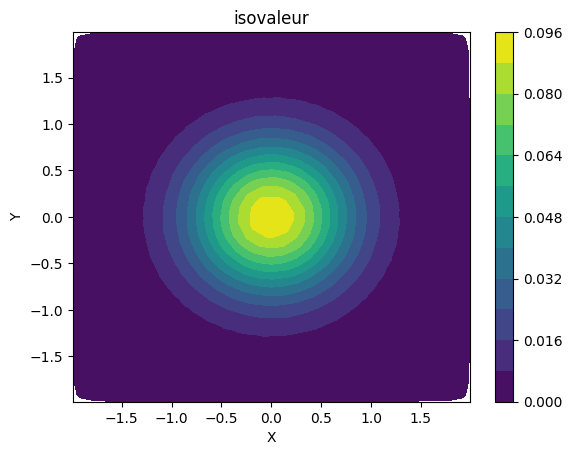

In [32]:
plot_isovaleurs(Orthocentre, u)

## TESt2

In [138]:
def distance_point_segment(P, A, B):
   # Convertir les points en numpy arrays pour faciliter les calculs
   P = np.array(P)
   A = np.array(A)
   B = np.array(B)
   
   # Vecteur AB
   AB = B - A
   # Vecteur AP
   AP = P - A
   
   # Projection de AP sur AB
   t = np.dot(AP, AB) / np.dot(AB, AB)
   
   # Trouver le point de projection sur le segment
   if t < 0.0:
       point_projection = A
   elif t > 1.0:
       point_projection = B
   else:
       point_projection = A + t * AB
   
   # Calculer la distance entre P et le point de projection
   distance = np.linalg.norm(P - point_projection)
   
   return distance

def barycentre(C):
   """
   Calcule le barycentre d'un triangle.
   
   Paramètres :
   C (numpy.ndarray) : Un tableau de forme (3, 2) contenant les coordonnées des sommets du triangle.
   
   Retour :
   tuple : Les coordonnées (x, y) du barycentre.
   """
   ax, ay = C[0][0], C[0][1]
   bx, by = C[1][0], C[1][1]
   cx, cy = C[2][0], C[2][1]
   
   # Calcul du barycentre
   x = (ax + bx + cx) / 3.0
   y = (ay + by + cy) / 3.0
   
   return (x, y)

def get_coord(k):
    C = Cells_Cord[k]
    ax, ay = Cells_Cord[k][0][0], Cells_Cord[k][0][1]
    bx, by = Cells_Cord[k][1][0], Cells_Cord[k][1][1]
    cx, cy = Cells_Cord[k][2][0], Cells_Cord[k][2][1]
    return [(ax,ay), (bx,by), (cx,cy)]
def Distances(k):
    list_faces = list(cells.faceid[k])
    sum = 0
    for edge in list_faces:
        triangles = faces.cellid[edge]
        vect1= get_coord[triangles[0]]
        vect2 = get_coord[triangles[1]]
        common_vertix = list(set(vect1) & set(vect2)
        B1 = barycentre(vect1)
        B2 = barycentre(vect2)
        dist1 = distance_point_segment(B1,coord[0],coord[1])
        dist2 = distance_point_segment(B2, coord[0],coord[1])

        mesure_edge = faces.mesure[edge]
        dist = mesure_edge/(dist1 + dist2)
        sum+=dist
    return sum



In [140]:
get_coord(-1)

[(-1.483458970144255, -1.779255838336899),
 (-1.389710547714234, -1.685670255544706),
 (-1.498547216717301, -1.661261168656972)]

In [123]:
list(cells.faceid[36])# Les arrêtes du triangle 36

[47, 51, 49]

In [124]:
faces.cellid[47] #Les trangles ayants le côté 47 en communs 

array([36, -1])

In [126]:
cells._nodeid[-1]#Les noeuds de du triangle -1

array([290, 787, 866])

In [127]:
cells._nodeid[36]

array([ 15,  16, 611])

In [133]:
faces.nodeid[47]

array([15, 16])

In [ ]:
somme = 0
for i in range(nbcells):
    k = cells.volume[i]
    dist = Distances(i)
    print(dist)
    #somme = max(somme, 1/k*dist)

lamda = 0.8
D = 1

dt = lamda/(D * somme)

print(dt)
